In [100]:
import os
import re
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
import requests
from scipy.interpolate import UnivariateSpline

%matplotlib inline
plt.rcParams['figure.figsize'] = (12, 6)

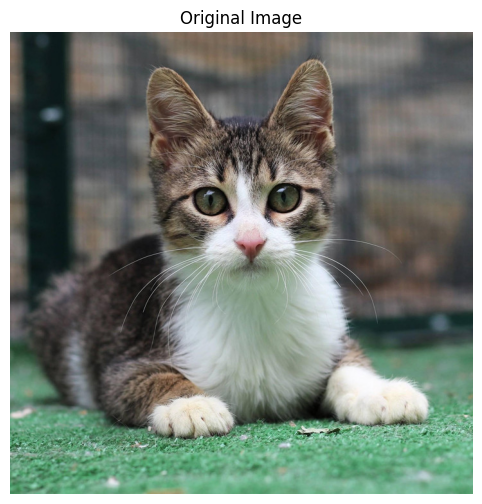

In [101]:
def load_image(path):
    img = cv2.imread(path)
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

img_path = 'image.png'
original_img = load_image(img_path)
plt.axis('off')
plt.title("Original Image")
plt.imshow(original_img)

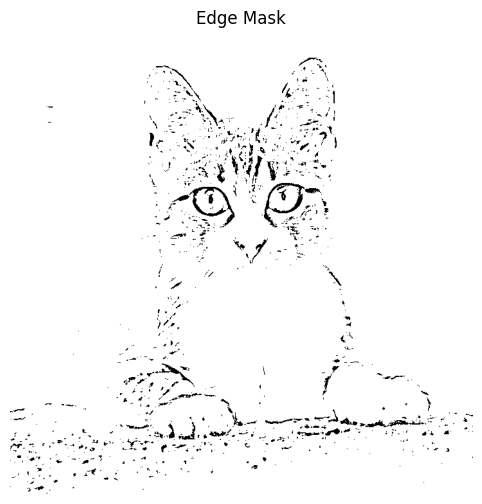

In [102]:
def generate_edge_mask(img, line_size=7, blur_value=7):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    blur = cv2.medianBlur(gray, blur_value)
    edges = cv2.adaptiveThreshold(
        blur, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
        cv2.THRESH_BINARY, line_size, blur_value
    )
    return edges

edges = generate_edge_mask(original_img)
plt.axis('off')
plt.title("Edge Mask")
plt.imshow(edges, cmap='gray')

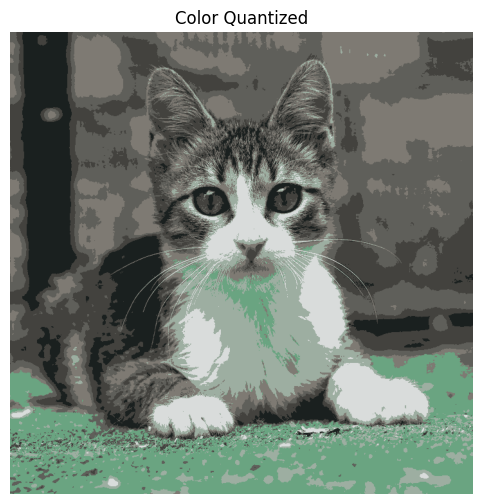

In [103]:
def color_quantization(img, k=7):
    data = img.reshape((-1, 3))
    kmeans = KMeans(n_clusters=k, random_state=42).fit(data)
    clustered = kmeans.cluster_centers_[kmeans.labels_]
    clustered_img = clustered.reshape(img.shape)
    return clustered_img.astype(np.uint8)

quantized_img = color_quantization(original_img)
plt.axis('off')
plt.title("Color Quantized")
plt.imshow(quantized_img)

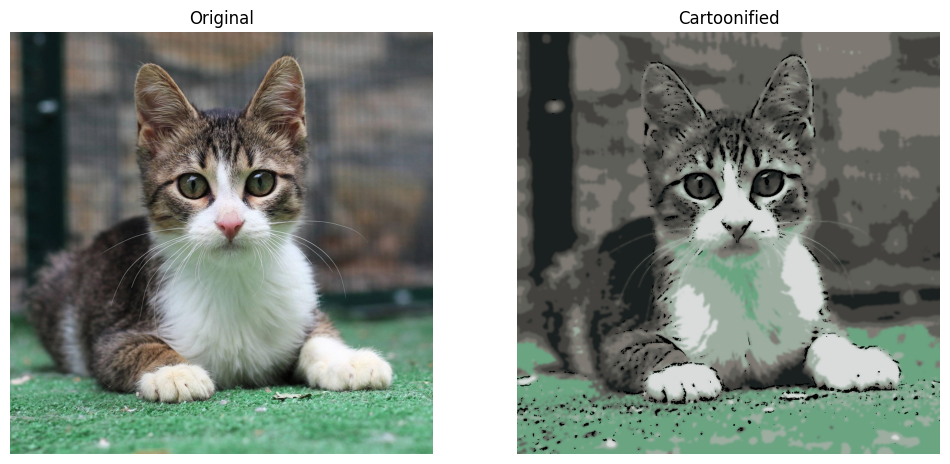

In [104]:
def apply_bilateral_filter(img):
    return cv2.bilateralFilter(img, d=7, sigmaColor=200, sigmaSpace=200)

def combine_edges_colors(color_img, edge_mask):
    return cv2.bitwise_and(color_img, color_img, mask=edge_mask)

smoothed_img = apply_bilateral_filter(quantized_img)
cartoon_img = combine_edges_colors(smoothed_img, edges)

# Display
plt.subplot(1, 2, 1)
plt.axis("off")
plt.title("Original")
plt.imshow(original_img)

plt.subplot(1, 2, 2)
plt.axis("off")
plt.title("Cartoonified")
plt.imshow(cartoon_img)

In [105]:
cartoon_bgr = cv2.cvtColor(cartoon_img, cv2.COLOR_RGB2BGR)
cv2.imwrite("cartoon_output.png", cartoon_bgr)

True

In [106]:
def cartoonify_method1(img, num_colors=8, blur_value=7, line_size=7):
    bilateral = cv2.bilateralFilter(img, d=15, sigmaColor=80, sigmaSpace=80)
    data = bilateral.reshape((-1, 3))
    kmeans = KMeans(n_clusters=num_colors, random_state=42, n_init=10)
    kmeans.fit(data)
    quantized_data = kmeans.cluster_centers_[kmeans.labels_]
    quantized_img = quantized_data.reshape(bilateral.shape).astype(np.uint8)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    blur = cv2.medianBlur(gray, blur_value)
    edges = cv2.adaptiveThreshold(blur, 255, cv2.ADAPTIVE_THRESH_MEAN_C, 
                                  cv2.THRESH_BINARY, line_size, blur_value)
    edges_colored = cv2.cvtColor(edges, cv2.COLOR_GRAY2RGB)
    cartoon = cv2.bitwise_and(quantized_img, edges_colored)
    return cartoon

def cartoonify_method2(img, num_colors=12, ksize=7):
    img_smooth = cv2.bilateralFilter(img, d=15, sigmaColor=200, sigmaSpace=200)
    data = img_smooth.reshape((-1, 3))
    kmeans = KMeans(n_clusters=num_colors, random_state=42, n_init=10)
    kmeans.fit(data)
    quantized_data = kmeans.cluster_centers_[kmeans.labels_]
    quantized_img = quantized_data.reshape(img_smooth.shape).astype(np.uint8)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    edges = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, 
                                  cv2.THRESH_BINARY, ksize, 10)
    edges = cv2.dilate(edges, np.ones((2,2), np.uint8), iterations=1)
    edges = cv2.erode(edges, np.ones((2,2), np.uint8), iterations=1)
    edges_colored = cv2.cvtColor(edges, cv2.COLOR_GRAY2RGB)
    edges_colored = 255 - edges_colored
    cartoon = cv2.multiply(quantized_img.astype(np.float32), 
                          edges_colored.astype(np.float32) / 255.0)
    return cartoon.astype(np.uint8)

def cartoonify_method3(img, num_colors=8, blur_value=7):
    smooth = img.copy()
    for _ in range(3):
        smooth = cv2.bilateralFilter(smooth, d=9, sigmaColor=200, sigmaSpace=200)
    data = smooth.reshape((-1, 3))
    kmeans = KMeans(n_clusters=num_colors, random_state=42, n_init=10)
    kmeans.fit(data)
    quantized_data = kmeans.cluster_centers_[kmeans.labels_]
    quantized = quantized_data.reshape(smooth.shape).astype(np.uint8)
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    edges = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C,
                                  cv2.THRESH_BINARY, blur_value, blur_value)
    edges = cv2.medianBlur(edges, 5)
    edges_3d = np.stack([edges, edges, edges], axis=2)
    cartoon = cv2.bitwise_and(quantized, edges_3d)
    return cartoon

def oil_painting_effect(img, size=7, dynRatio=1):
    return cv2.xphoto.oilPainting(img, size, dynRatio)

def pencil_sketch_cartoon(img):
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    inv_gray = 255 - gray
    blur_inv = cv2.GaussianBlur(inv_gray, (25, 25), 0, 0)
    sketch = cv2.divide(gray, 255 - blur_inv, scale=256)
    cartoon = cv2.bilateralFilter(img, d=20, sigmaColor=200, sigmaSpace=200)
    data = cartoon.reshape((-1, 3))
    data = np.float32(data)
    criteria = (cv2.TERM_CRITERIA_EPS + cv2.TERM_CRITERIA_MAX_ITER, 10, 1.0)
    _, labels, centers = cv2.kmeans(data, 6, None, criteria, 10, cv2.KMEANS_RANDOM_CENTERS)
    centers = np.uint8(centers)
    cartoon_quantized = centers[labels.flatten()].reshape(img.shape)
    edges = cv2.adaptiveThreshold(gray, 255, cv2.ADAPTIVE_THRESH_MEAN_C, 
                                  cv2.THRESH_BINARY, 7, 7)
    sketch_3d = cv2.cvtColor(sketch, cv2.COLOR_GRAY2RGB)
    edges_3d = cv2.cvtColor(edges, cv2.COLOR_GRAY2RGB)
    edges_mask = edges_3d.astype(np.float32) / 255.0
    cartoon_float = cartoon_quantized.astype(np.float32) / 255.0
    sketch_float = sketch_3d.astype(np.float32) / 255.0
    result = cartoon_float * edges_mask * sketch_float
    return np.clip(result * 255, 0, 255).astype(np.uint8)

def enhanced_cartoon(img, flags=2, sigma_s=50, sigma_r=0.4, k=7):
    smooth = cv2.edgePreservingFilter(img, flags=flags, sigma_s=sigma_s, sigma_r=sigma_r)
    data = smooth.reshape((-1, 3))
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(data)
    quantized_data = kmeans.cluster_centers_[kmeans.labels_]
    quantized = quantized_data.reshape(smooth.shape).astype(np.uint8)
    return quantized

In [107]:
def sanitize_filename(name):
    """Replace spaces and special characters for safe filenames"""
    name = re.sub(r'[^a-zA-Z0-9_]', '_', name)  # Only alphanumeric + underscore
    return name.lower().strip('_')

def compare_methods(img_path, save_dir="cartoon_outputs"):
    img = load_image(img_path)
    
    methods = [
        ("Method 1: Enhanced Current", cartoonify_method1(img)),
        ("Method 2: Advanced Filter", cartoonify_method2(img)),
        ("Method 3: Anime Style", cartoonify_method3(img)),
        ("Method 4: Oil Painting", oil_painting_effect(img)),
        ("Method 5: Pencil + Color", pencil_sketch_cartoon(img)),
        ("Method 6: Edge Preserving", enhanced_cartoon(img))
    ]

    os.makedirs(save_dir, exist_ok=True)

    cols = 3
    rows = int(np.ceil(len(methods) / cols))
    fig, axes = plt.subplots(rows, cols, figsize=(16, 5 * rows))
    axes = axes.ravel()

    for i, (title, image) in enumerate(methods):
        axes[i].imshow(image)
        axes[i].set_title(title)
        axes[i].axis('off')

        filename = sanitize_filename(title) + ".png"
        full_path = os.path.join(save_dir, filename)
        image_bgr = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        success = cv2.imwrite(full_path, image_bgr)
        if not success:
            print(f"Failed to save {title} at {full_path}")
        else:
            print(f"Saved: {full_path}")

    for j in range(len(methods), len(axes)):
        axes[j].axis('off')

    plt.tight_layout()
    plt.show()

Saved: cartoon_outputs\method_1__enhanced_current.png
Saved: cartoon_outputs\method_2__advanced_filter.png
Saved: cartoon_outputs\method_3__anime_style.png
Saved: cartoon_outputs\method_4__oil_painting.png
Saved: cartoon_outputs\method_5__pencil___color.png
Saved: cartoon_outputs\method_6__edge_preserving.png


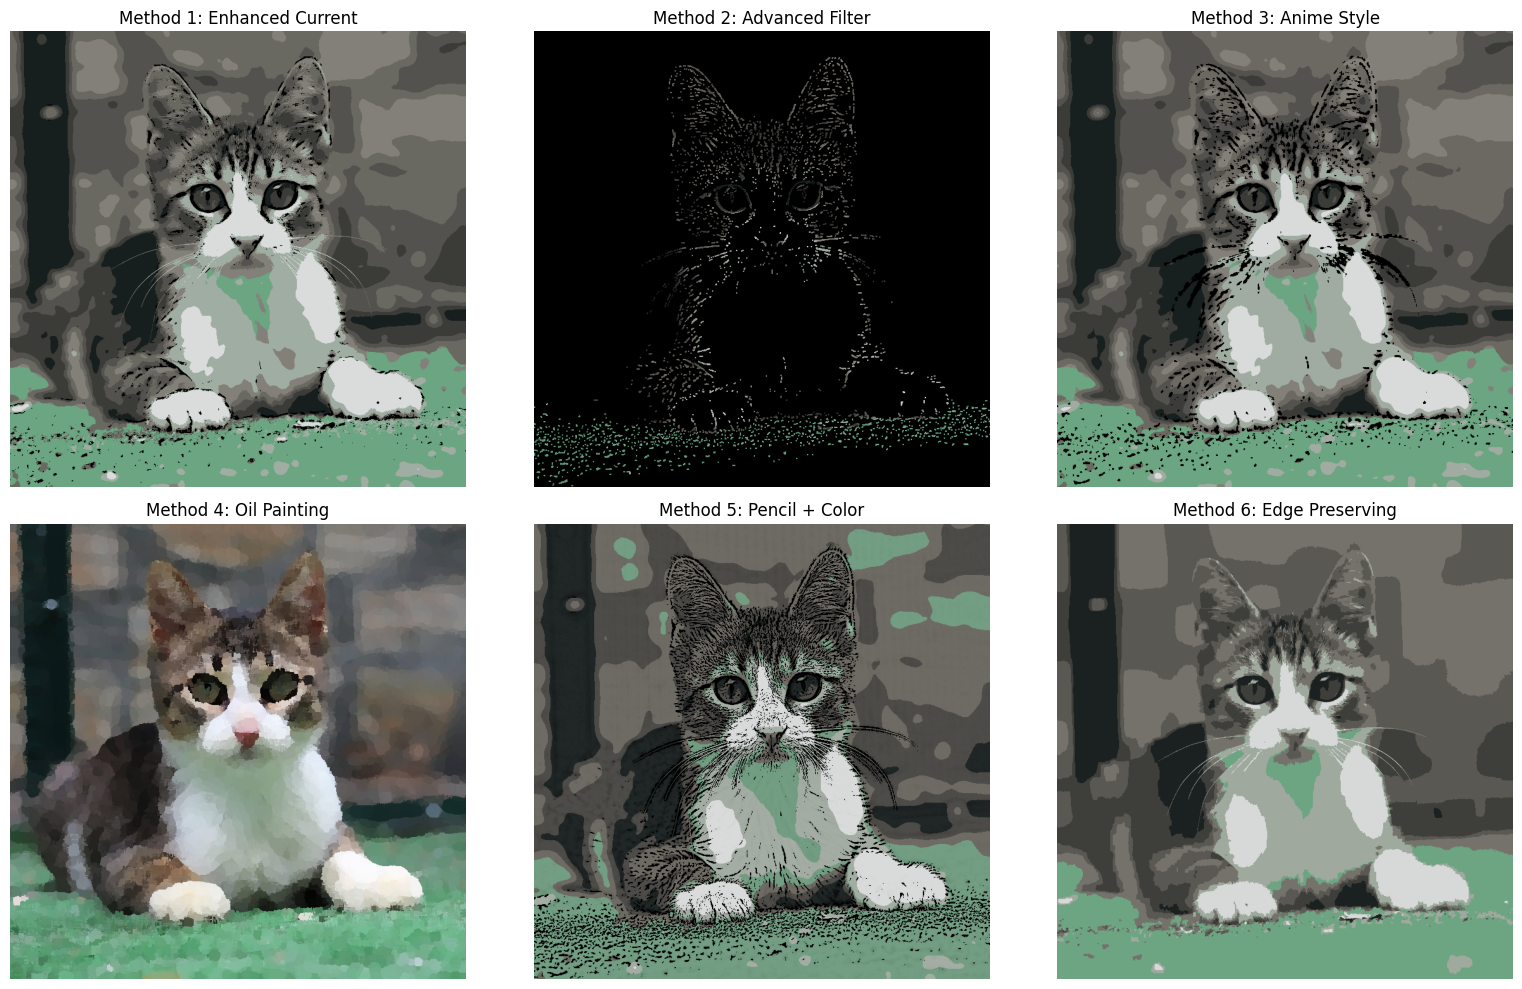

In [108]:
compare_methods("image.png")